## Afternoon practical day 3

You've just learned about convolutional neural networks. There will be a sneak peek into them at the end. For now, however, we finally implement backpropagation.



In [1]:
#run this cell to set things up
import ipywidgets as widgets, numpy as np, pandas as pd
from numpy.random import default_rng
%matplotlib inline
import matplotlib.pyplot as plt
import math
import seaborn as sns
from IPython.display import display, Markdown, Math
from scipy.optimize import fmin_bfgs, fmin_cg, fmin
import sklearn

In [26]:
#important functions
def mySigmoid(data):
    data= np.array(data)
    output = 1/(1+ np.exp(-data))
    return output

def mySigmoidGradient(x):
    outcome = mySigmoid(x) * (1-mySigmoid(x))
    return outcome

def nnCostFunction(nnThetas, X, y, lambda_ = 0, inputLayerSize = 784, hiddenLayerSize = 25, classLabels = 10):
   
    m = len(X)
    
    #reshaping the list of parameters to matrices
    hiddenLayerParamNr    = (hiddenLayerSize * (inputLayerSize+1))
    thetaOneMatrix        = np.reshape(nnThetas[0:hiddenLayerParamNr],
                                       newshape = (hiddenLayerSize, inputLayerSize+1))
    outputLayerParamStart = hiddenLayerParamNr 
    thetaTwoMatrix        = np.reshape(nnThetas[outputLayerParamStart:],
                                       newshape = (classLabels, hiddenLayerSize+1))
    
    #calculating the forward pass
    inputs        = np.c_[np.ones(shape = (len(X), 1)), X]
    weightedSumHL = inputs @ thetaOneMatrix.T
    activationsHL  = mySigmoid(weightedSumHL)
    
    inputsOL      = np.c_[np.ones(shape = (len(activationsHL), 1)), activationsHL]
    weightedSumOL = inputsOL @ thetaTwoMatrix.T
    activationsOL = mySigmoid(weightedSumOL)
    
    #cost
    J = 1/m * np.sum((- (y * np.log(activationsOL)) - ((1-y) * np.log(1-activationsOL))))
    
    #regularised cost
    #remember: units in the rows, their parameters in the columns
    #Hence, [:,1:] removes the columns with the bias term.
    regThetaOne = np.sum(np.square(thetaOneMatrix[:,1:]))
    regThetaTwo = np.sum(np.square(thetaTwoMatrix[:,1:]))
    regCost     = J + (lambda_/(2*m)) * (regThetaOne + regThetaTwo)
    
    return regCost

def numericalGradientApproximation(nnThetas, X, y, lambda_ = 0, e = 1e-4, indexToStop = 500):
    nnThetasMinusE = nnThetas-e
    nnThetasPlusE  = nnThetas+e
    listGradients = []
    for index, value in enumerate(nnThetas):
        if index % 50 == 0:
            print("Parameter " + str(index) + " out of " + str(len(nnThetas)))
        minusEThetas = nnThetas; minusEThetas[index] = nnThetasMinusE[index]
        minusECost   = nnCostFunction(minusEThetas, X, y, lambda_)
        plusEThetas  = nnThetas; plusEThetas[index] = nnThetasPlusE[index]
        plusECost    = nnCostFunction(plusEThetas, X, y, lambda_)
        numericalGradApproxThisTheta = (plusECost - minusECost)/(2*e)
        #Only do this for the first ~150 thetas. Otherwise it takes entirely too long!
        listGradients.append(numericalGradApproxThisTheta)
        if index == indexToStop:
            break
    return np.array(listGradients)

## Implementing backpropagation part 2: the real deal

Part of the equations you need to implement are in this figure, namely the calculation of the error per unit. Note that this figure has these calculations for **1 training example**. In reality we want to implement them with linear algebra such that we calculate for all training examples at the same time:
![NNBackProp](NeuralNetworkBackprop.PNG)

Concretely:
* You can calculate the error for the output layer $\delta^{(3)}$: that's the activations for this training sample minus its label vector. **WAAROM NIET * sigma'(z^(3))?**
* You can use these to calculate $\delta^{(2)}$: $(\Theta^{(2)})^T \cdot \delta^{(3)} \odot sigmoidGradient(z^{(2)}) $. Here, .* or $\odot$ is elementwise multiplication, which is just * for numpy. This calculates the part of the error that is due to the Hidden Layer weighing its inputs wrong. 
* The remove $\delta_0^{(2)}$ just means that you shouldn't calculate a gradient for the +1 neuron: it's not connected to the previous layer so there's nothing to propagate back!
* There's no error for the input layer, so after this you're done propagating the error, but you do need to change the weights of the Hidden Layer!

This might seem a little bit simple, but it performs all we need to do.
$\delta^{(3)}$ is a (10, 1) vector containing at each position how wrong a given neuron was for a prediction (or averaged over predictions of many samples). $(\Theta^{(2)})^T$ is a (10, 26)$^T$ = (26, 10) matrix. So 26 rows: 25 units, 10 columns containing the weights of each unit to the 10 units in the output layer, and 1 row with the 10 biases, 1 for each output layer unit. When we multiply this with the error in the output layer (10, 1), we get for each output unit's weights and the biases how their _activations_ should be changed to decrease the error. We change their activations by changing the inputs to the activation function (_weights and biases_), so we should take the derivative of the activation function for these values to find the gradients to step down to change the weights and biases so as to reduce the error in the output layer. Just to be clear: $z^{(2)}$ is the weighted sum that layer 2 generates using matrix $\Theta^{(1)}$.

Up to you to:
* Make a copy of `nnCostFunction`. Call it `nnGradientFunction`. It keeps the same arguments and does exactly the same to begin with, but it will return the gradients calculated by backpropagation rather than stop at calculating the cost function. First set it to return `None`. 
* Calculate $\delta^{(3)}$ using the cost.
* Calculate $\delta^{(2)}$ using $\delta^{(3)}$. For _one_ training example that would be the formula above. But remember, you have a matrix of shape (20,004 x 10). With the first row corresponding to the errors on the first training example,  etc. 

In [19]:
from numpy.random import default_rng
rng = default_rng(42)
thetaOneMatrix = rng.uniform(-0.12, 0.12, size = (25, 785))
thetaTwoMatrix = rng.uniform(-0.12, 0.12, size = (10, 26))

savedData = np.load("dataMNISTNeuralNetwork.npz")
X_train, X_test, y_train, y_test = savedData["XTrain"], savedData["XTest"], savedData["yTrain"], savedData["yTest"]


nnThetas       = np.append(np.ravel(thetaOneMatrix), np.ravel(thetaTwoMatrix))
inputLayerSize = 784
hiddenLayerSize = 25
classLabels = 10
X = X_train
y = y_train


# answer

def nnGradientFunction(nnThetas, X, y, lambda_ = 0, inputLayerSize = 784, hiddenLayerSize = 25, classLabels = 10):
   
    m = len(X)
    
    #reshaping the list of parameters to matrices
    hiddenLayerParamNr    = (hiddenLayerSize * (inputLayerSize+1))
    thetaOneMatrix        = np.reshape(nnThetas[0:hiddenLayerParamNr],
                                       newshape = (hiddenLayerSize, inputLayerSize+1))
    outputLayerParamStart = hiddenLayerParamNr 
    thetaTwoMatrix        = np.reshape(nnThetas[outputLayerParamStart:],
                                       newshape = (classLabels, hiddenLayerSize+1))
    
    #calculating the forward pass
    inputs        = np.c_[np.ones(shape = (len(X), 1)), X]
    weightedSumHL = inputs @ thetaOneMatrix.T
    activationsHL  = mySigmoid(weightedSumHL)
    
    inputsOL      = np.c_[np.ones(shape = (len(activationsHL), 1)), activationsHL]
    weightedSumOL = inputsOL @ thetaTwoMatrix.T
    activationsOL = mySigmoid(weightedSumOL)
    
    print("Activations output layer shape: " + str(activationsOL.shape))
    print("Activations for one training example: " + str(activationsOL[0,:]))
    
    #cost
    J = 1/m * np.sum((- (y * np.log(activationsOL)) - ((1-y) * np.log(1-activationsOL))))
    
    #regularised cost
    #remember: units in the rows, their parameters in the columns
    #Hence, [:,1:] removes the columns with the bias term.
    regThetaOne = np.sum(np.square(thetaOneMatrix[:,1:]))
    regThetaTwo = np.sum(np.square(thetaTwoMatrix[:,1:]))
    regCost     = J + (lambda_/(2*m)) * (regThetaOne + regThetaTwo)
    
    
    #calculate error layer 3
    smallDeltaThree = activationsOL - y
    print("delta^(3): " + str(smallDeltaThree))
    print("delta^(3) shape: " + str(smallDeltaThree.shape) + "\n")
    
    #calculate the weighted sums that the HL generates that go into the activation function and then get sent to 
    #the output layer
    weightedSumsLayerTwo = zTwo = weightedSumHL #= np.c_[np.ones(shape = (len(X), 1)), X] @ thetaOneMatrix.T
    print("z^(2): " + str(zTwo))
    print("z^(2) shape: " + str(zTwo.shape) + "\n")
    
    sigmoidGradientOfZTwo = mySigmoidGradient(zTwo)
    print("Sigmoid gradient: " + str(sigmoidGradientOfZTwo))
    print("Sigmoid gradient shape: " + str(sigmoidGradientOfZTwo.shape))
    smallDeltaTwo   = smallDeltaThree @ thetaTwoMatrix * np.c_[np.ones(shape = (len(X), 1)),
                                                               mySigmoidGradient(zTwo)]
    smallDeltaTwo   = smallDeltaTwo[:, 1:]
    print("delta^(2): " + str(smallDeltaTwo))
    print("size of delta^(2): " + str(smallDeltaTwo.shape)) 
    
    
    bigDeltaThree     = smallDeltaThree.T @ np.c_[np.ones(shape = len(activationsHL)),
                                                 activationsHL]
    print("Gradients output layer: " + str(bigDeltaThree))
    print("Gradients output layer shape: " + str(bigDeltaThree))
    
    bigDeltaTwo       = smallDeltaTwo.T   @ np.c_[np.ones(shape = len(X)),
                                                 X]
    print("Gradients hidden layer: " + str(bigDeltaTwo))
    print("Gradients hidden layer shape: " + str(bigDeltaTwo))
    
    #average values, we've now summed them over all training examples
    bigDeltaTwo   = bigDeltaTwo   * 1/m
    bigDeltaThree = bigDeltaThree * 1/m

    finalGradients = np.append(np.ravel(bigDeltaTwo), np.ravel(bigDeltaThree))
    
    return finalGradients

test = nnGradientFunction(nnThetas, X, y)
print(test.shape)
print(nnThetas.shape)

Activations output layer shape: (20004, 10)
Activations for one training example: [0.50679905 0.47026724 0.48045209 0.45695882 0.50439269 0.42537011
 0.45660324 0.55061342 0.58567024 0.48573213]
delta^(3): [[ 0.50679905  0.47026724  0.48045209 ...  0.55061342  0.58567024
  -0.51426787]
 [ 0.51597866  0.47184661  0.47270976 ...  0.57208504  0.58398438
  -0.52566946]
 [ 0.50011956  0.45834984  0.47915344 ...  0.55698424  0.59916884
  -0.51727237]
 ...
 [-0.46315771  0.47886494  0.45896251 ...  0.56575545  0.59230702
   0.48211795]
 [-0.47937306  0.46951334  0.45806689 ...  0.54667469  0.58760281
   0.47131704]
 [-0.48248302  0.47086103  0.45044764 ...  0.56747375  0.60631971
   0.48869242]]
delta^(3) shape: (20004, 10)

z^(2): [[ 1.47211529  0.72742786 -0.61089524 ...  0.31187328 -0.9862839
  -0.24400619]
 [ 1.97432473  1.22491872 -1.0079633  ...  0.44606513 -0.53983498
   0.30598892]
 [ 1.79004393  0.16434479 -0.54288865 ...  1.06426415 -0.48233109
  -0.21282825]
 ...
 [ 0.38756623  1.6

Gradients hidden layer: [[-221.88941345    0.            0.         ...    0.
     0.            0.        ]
 [ 130.18579792    0.            0.         ...    0.
     0.            0.        ]
 [  33.42637502    0.            0.         ...    0.
     0.            0.        ]
 ...
 [-487.67420661    0.            0.         ...    0.
     0.            0.        ]
 [ 140.56213249    0.            0.         ...    0.
     0.            0.        ]
 [  38.66465763    0.            0.         ...    0.
     0.            0.        ]]
Gradients hidden layer shape: [[-221.88941345    0.            0.         ...    0.
     0.            0.        ]
 [ 130.18579792    0.            0.         ...    0.
     0.            0.        ]
 [  33.42637502    0.            0.         ...    0.
     0.            0.        ]
 ...
 [-487.67420661    0.            0.         ...    0.
     0.            0.        ]
 [ 140.56213249    0.            0.         ...    0.
     0.            0.        ]


## Testing your calculations with numerical gradient computations

Implementing backpropagation probably took entirely too long. That's not strange: while the idea is not strange, pouring it correctly into the linear algebra mould when you've only just learned about it is entirely difficult. Hopefully you managed to make it through, with or without the answers. Now we're going to check that the gradients we've calculated are correct. For that, let's use the numerical gradient computation function defined earlier. The implementation in the second cell of this notebook stops after the first _indexToStop_ (here 500) theta parameters (out of a whopping 19,885) because otherwise it would take _hours_. 

This is of course just an approximation, so the gradients will only be correct up to the first ~3 digits after the comma. Let's check that the rounded entries of the numerical approximation agree with those of the actual gradient computation via backpropagation.

In [34]:
#Don't run this cell multiple times! 
numericApproxGrad = numericalGradientApproximation(nnThetas, X, y, indexToStop = 500)
roundedNumApproxGrad = np.round(numericApproxGrad, 3)
print(roundedNumApproxGrad)

print(roundedNumApproxGrad[np.where(roundedNumApproxGrad != 0)])
print(np.round(test,3)[np.where(roundedNumApproxGrad != 0)])
#are these rounded entries all the same?
print(np.all(np.round(test,3)[0:len(roundedNumApproxGrad)] == roundedNumApproxGrad))

Parameter 0 out of 19885


KeyboardInterrupt: 

## Moving on: adding regularisation and training the network

If the above did not return the same values for you and you've been repeatedly smashing your face into your desk, laptop, or other assorted objects in the vicinity out of frustration, feel free to copy the correct implementation of nnGradientFunction from the answers. It's now time to add one last change: we need to add regularisation to the gradients (partial derivatives) of ourt theta's. 

Luckily, it turns out that, like before, you can do this after you've already computed the gradients: 
![RegularisationCostAddedToGradients](RegularisationCostAddedToGradients.PNG)

This shows it in a loop. But we have the gradients of our two theta matrices. And so, you can simply add $$\frac{\lambda}{m} \cdot \Theta^{(1)}$$ to $\Theta^{(1)}$ (excluding the biases in the first column!), and likewise, $$\frac{\lambda}{m} \cdot \Theta^{(2)}$$ to $\Theta^{(2)}$ (again, do nothing to the bias terms!). <br> <br>

Up to you to:
* Copy the nnGradientFunction from above (or edit it in-place) and add the regularisation terms to the gradient!

Hint:
* The easiest implementation is to just set the first column of `thetaOneMatrix` and `thetaTwoMatrix` to 0, and to then add them $\cdot \frac{\lambda}{m}$ to the matrices of gradients you calculated before.

In [37]:
# answer

def nnGradientFunction(nnThetas, X, y, lambda_ = 0, inputLayerSize = 784, hiddenLayerSize = 25, classLabels = 10,
                      printInternalProgress = False):
   
    m = len(X)
    
    #reshaping the list of parameters to matrices
    hiddenLayerParamNr    = (hiddenLayerSize * (inputLayerSize+1))
    thetaOneMatrix        = np.reshape(nnThetas[0:hiddenLayerParamNr],
                                       newshape = (hiddenLayerSize, inputLayerSize+1))
    outputLayerParamStart = hiddenLayerParamNr 
    thetaTwoMatrix        = np.reshape(nnThetas[outputLayerParamStart:],
                                       newshape = (classLabels, hiddenLayerSize+1))
    
    #calculating the forward pass
    inputs        = np.c_[np.ones(shape = (len(X), 1)), X]
    weightedSumHL = inputs @ thetaOneMatrix.T
    activationsHL  = mySigmoid(weightedSumHL)
    
    inputsOL      = np.c_[np.ones(shape = (len(activationsHL), 1)), activationsHL]
    weightedSumOL = inputsOL @ thetaTwoMatrix.T
    activationsOL = mySigmoid(weightedSumOL)
    
    if printInternalProgress:
        print("Activations output layer shape: " + str(activationsOL.shape))
        print("Activations for one training example: " + str(activationsOL[0,:]))
    
    #cost
    J = 1/m * np.sum((- (y * np.log(activationsOL)) - ((1-y) * np.log(1-activationsOL))))
    
    #regularised cost
    #remember: units in the rows, their parameters in the columns
    #Hence, [:,1:] removes the columns with the bias term.
    regThetaOne = np.sum(np.square(thetaOneMatrix[:,1:]))
    regThetaTwo = np.sum(np.square(thetaTwoMatrix[:,1:]))
    regCost     = J + (lambda_/(2*m)) * (regThetaOne + regThetaTwo)
    
    
    #calculate error layer 3
    smallDeltaThree = activationsOL - y
    if printInternalProgress:
        print("delta^(3): " + str(smallDeltaThree))
        print("delta^(3) shape: " + str(smallDeltaThree.shape) + "\n")
    
    #calculate the weighted sums that the HL generates that go into the activation function and then get sent to 
    #the output layer
    weightedSumsLayerTwo = zTwo = weightedSumHL #= np.c_[np.ones(shape = (len(X), 1)), X] @ thetaOneMatrix.T
    if printInternalProgress:
        print("z^(2): " + str(zTwo))
        print("z^(2) shape: " + str(zTwo.shape) + "\n")
    
    sigmoidGradientOfZTwo = mySigmoidGradient(zTwo)
    if printInternalProgress:
        print("Sigmoid gradient: " + str(sigmoidGradientOfZTwo))
        print("Sigmoid gradient shape: " + str(sigmoidGradientOfZTwo.shape))
    smallDeltaTwo   = smallDeltaThree @ thetaTwoMatrix * np.c_[np.ones(shape = (len(X), 1)),
                                                               mySigmoidGradient(zTwo)]
    smallDeltaTwo   = smallDeltaTwo[:, 1:]
    if printInternalProgress:
        print("delta^(2): " + str(smallDeltaTwo))
        print("size of delta^(2): " + str(smallDeltaTwo.shape)) 
    
    
    bigDeltaThree     = smallDeltaThree.T @ np.c_[np.ones(shape = len(activationsHL)),
                                                 activationsHL]
    if printInternalProgress:
        print("Gradients output layer: " + str(bigDeltaThree))
        print("Gradients output layer shape: " + str(bigDeltaThree))
    
    bigDeltaTwo       = smallDeltaTwo.T   @ np.c_[np.ones(shape = len(X)),
                                                 X]
    if printInternalProgress:
        print("Gradients hidden layer: " + str(bigDeltaTwo))
        print("Gradients hidden layer shape: " + str(bigDeltaTwo))
    
    #average values, we've now summed them over all training examples
    bigDeltaTwo   = bigDeltaTwo   * 1/m
    bigDeltaThree = bigDeltaThree * 1/m
    
    #add the regularisation cost into the gradients
    thetaOneMatrix[:, 0] = 0
    bigDeltaTwo   += lambda_/m * thetaOneMatrix
    thetaTwoMatrix[:, 0] = 0
    bigDeltaThree += lambda_/m * thetaTwoMatrix

    finalGradients = np.append(np.ravel(bigDeltaTwo), np.ravel(bigDeltaThree))
    
    return finalGradients

testRegularised = nnGradientFunction(nnThetas, X, y, lambda_ = 50)
print(testRegularised.shape)
print(nnThetas.shape)
print(test[0:30])
print(testRegularised[0:30])

(19885,)
(19885,)
[-1.10922522e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -3.91994057e-08 -8.46707142e-07 -8.46707142e-07
 -3.52794655e-08  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
[-1.09200135e-02 -3.61657030e-05  2.15615629e-04  1.18897038e-04
 -2.42945002e-04  2.85816248e-04  1.57152391e-04  1.71854212e-04
 -2.22837253e-04 -2.95125348e-05 -7.72557343e-05  2.56257742e-04
  8.65517617e-05  1.93828809e-04 -3.45454731e-05 -1.64224823e-04
  3.29588262e-05 -2.61407365e-04  1.96789345e-04  7.92327929e-05
  1.55071630e-04 -8.70170157e-05  2.82612292e-04  2.36075458e-04
  1.67246649e-04 -1.82930189e-04 -1.97134551e-05 -2.73413058e-04
 -2.07134878e-04  1.10057360e-04]


## Training the neural network with your brand-spankin' new function

Finally, the time has come to face your destiny: training a neural network to classify some digits in an afternoon practical. It's a simple destiny, as destinies go, but a worthwhile one nonetheless. Besides, the other choice is facing the fact that destinies don't exist and existence is meaningless, so have at it!

* Use your favourite pal `fmin_cg` to minimise this function. If you forgot how it worked, look back to when you used it yesterday or see the documentation [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fmin_cg.html). Assign the result to `trainedNeuralNetwork`. Be sure to set `maxiter = 60`.

Hint:
* This will take ~10 minutes to run. Feel free to grab something to drink or take a short walk. 

In [70]:

rng = default_rng(42)
thetaOneMatrix = rng.uniform(-0.12, 0.12, size = (25, 785))
thetaTwoMatrix = rng.uniform(-0.12, 0.12, size = (10, 26))
initialThetas = np.append(np.ravel(thetaOneMatrix), np.ravel(thetaTwoMatrix))


#answer
def printProgress(xk):
    print("Current theta values: " + str(xk))

# trainedNeuralNetwork = fmin_cg(f = nnCostFunction, x0 = initialThetas, fprime = nnGradientFunction,
#                                args = (X_train, y_train, 1), callback = printProgress, maxiter = 60)

#I used this to generate the values for longer training, and with different lambdas
# trainedNeuralNetworkLongerLambdaZero = fmin_cg(f = nnCostFunction, x0 = initialThetas, fprime = nnGradientFunction,
#                                args = (X_train, y_train, 0), maxiter = 500)
# trainedNeuralNetworkLongerLambdaOne = fmin_cg(f = nnCostFunction, x0 = initialThetas, fprime = nnGradientFunction,
#                                args = (X_train, y_train, 1), maxiter = 500)
# trainedNeuralNetworkLongerLambdaTen = fmin_cg(f = nnCostFunction, x0 = initialThetas, fprime = nnGradientFunction,
#                                args = (X_train, y_train, 10), maxiter = 500)
# trainedNeuralNetworkLongerLambdaHundred = fmin_cg(f = nnCostFunction, x0 = initialThetas, fprime = nnGradientFunction,
#                                args = (X_train, y_train, 100), maxiter = 500)

# np.savez_compressed("500IterationsTrainedThetasLambdas0_1_10_100",
#                    thetaListLambdaZero    = trainedNeuralNetworkLongerLambdaZero,
#                    thetaListLambdaOne     = trainedNeuralNetworkLongerLambdaOne,
#                    thetaListLambdaTen     = trainedNeuralNetworkLongerLambdaTen,
#                    thetaListLambdaHundred = trainedNeuralNetworkLongerLambdaHundred)


<ipython-input-26-60c1c7ae877b>:33: RuntimeWarning: divide by zero encountered in log
  J = 1/m * np.sum((- (y * np.log(activationsOL)) - ((1-y) * np.log(1-activationsOL))))
<ipython-input-26-60c1c7ae877b>:33: RuntimeWarning: invalid value encountered in multiply
  J = 1/m * np.sum((- (y * np.log(activationsOL)) - ((1-y) * np.log(1-activationsOL))))
<ipython-input-37-70a390cceac0>:30: RuntimeWarning: divide by zero encountered in log
  J = 1/m * np.sum((- (y * np.log(activationsOL)) - ((1-y) * np.log(1-activationsOL))))
<ipython-input-37-70a390cceac0>:30: RuntimeWarning: invalid value encountered in multiply
  J = 1/m * np.sum((- (y * np.log(activationsOL)) - ((1-y) * np.log(1-activationsOL))))
<ipython-input-26-60c1c7ae877b>:33: RuntimeWarning: divide by zero encountered in log
  J = 1/m * np.sum((- (y * np.log(activationsOL)) - ((1-y) * np.log(1-activationsOL))))
<ipython-input-26-60c1c7ae877b>:33: RuntimeWarning: invalid value encountered in multiply
  J = 1/m * np.sum((- (y * np.lo

<ipython-input-26-60c1c7ae877b>:33: RuntimeWarning: divide by zero encountered in log
  J = 1/m * np.sum((- (y * np.log(activationsOL)) - ((1-y) * np.log(1-activationsOL))))
<ipython-input-26-60c1c7ae877b>:33: RuntimeWarning: invalid value encountered in multiply
  J = 1/m * np.sum((- (y * np.log(activationsOL)) - ((1-y) * np.log(1-activationsOL))))
<ipython-input-37-70a390cceac0>:30: RuntimeWarning: divide by zero encountered in log
  J = 1/m * np.sum((- (y * np.log(activationsOL)) - ((1-y) * np.log(1-activationsOL))))
<ipython-input-37-70a390cceac0>:30: RuntimeWarning: invalid value encountered in multiply
  J = 1/m * np.sum((- (y * np.log(activationsOL)) - ((1-y) * np.log(1-activationsOL))))
<ipython-input-26-60c1c7ae877b>:33: RuntimeWarning: divide by zero encountered in log
  J = 1/m * np.sum((- (y * np.log(activationsOL)) - ((1-y) * np.log(1-activationsOL))))
<ipython-input-26-60c1c7ae877b>:33: RuntimeWarning: invalid value encountered in multiply
  J = 1/m * np.sum((- (y * np.lo

<ipython-input-37-70a390cceac0>:30: RuntimeWarning: invalid value encountered in multiply
  J = 1/m * np.sum((- (y * np.log(activationsOL)) - ((1-y) * np.log(1-activationsOL))))
<ipython-input-26-60c1c7ae877b>:33: RuntimeWarning: divide by zero encountered in log
  J = 1/m * np.sum((- (y * np.log(activationsOL)) - ((1-y) * np.log(1-activationsOL))))
<ipython-input-26-60c1c7ae877b>:33: RuntimeWarning: invalid value encountered in multiply
  J = 1/m * np.sum((- (y * np.log(activationsOL)) - ((1-y) * np.log(1-activationsOL))))
<ipython-input-37-70a390cceac0>:30: RuntimeWarning: divide by zero encountered in log
  J = 1/m * np.sum((- (y * np.log(activationsOL)) - ((1-y) * np.log(1-activationsOL))))
<ipython-input-37-70a390cceac0>:30: RuntimeWarning: invalid value encountered in multiply
  J = 1/m * np.sum((- (y * np.log(activationsOL)) - ((1-y) * np.log(1-activationsOL))))
<ipython-input-26-60c1c7ae877b>:33: RuntimeWarning: divide by zero encountered in log
  J = 1/m * np.sum((- (y * np.lo

<ipython-input-37-70a390cceac0>:30: RuntimeWarning: divide by zero encountered in log
  J = 1/m * np.sum((- (y * np.log(activationsOL)) - ((1-y) * np.log(1-activationsOL))))
<ipython-input-37-70a390cceac0>:30: RuntimeWarning: invalid value encountered in multiply
  J = 1/m * np.sum((- (y * np.log(activationsOL)) - ((1-y) * np.log(1-activationsOL))))
<ipython-input-26-60c1c7ae877b>:33: RuntimeWarning: divide by zero encountered in log
  J = 1/m * np.sum((- (y * np.log(activationsOL)) - ((1-y) * np.log(1-activationsOL))))
<ipython-input-26-60c1c7ae877b>:33: RuntimeWarning: invalid value encountered in multiply
  J = 1/m * np.sum((- (y * np.log(activationsOL)) - ((1-y) * np.log(1-activationsOL))))
<ipython-input-37-70a390cceac0>:30: RuntimeWarning: divide by zero encountered in log
  J = 1/m * np.sum((- (y * np.log(activationsOL)) - ((1-y) * np.log(1-activationsOL))))
<ipython-input-37-70a390cceac0>:30: RuntimeWarning: invalid value encountered in multiply
  J = 1/m * np.sum((- (y * np.lo

<ipython-input-37-70a390cceac0>:30: RuntimeWarning: invalid value encountered in multiply
  J = 1/m * np.sum((- (y * np.log(activationsOL)) - ((1-y) * np.log(1-activationsOL))))
<ipython-input-26-60c1c7ae877b>:33: RuntimeWarning: divide by zero encountered in log
  J = 1/m * np.sum((- (y * np.log(activationsOL)) - ((1-y) * np.log(1-activationsOL))))
<ipython-input-26-60c1c7ae877b>:33: RuntimeWarning: invalid value encountered in multiply
  J = 1/m * np.sum((- (y * np.log(activationsOL)) - ((1-y) * np.log(1-activationsOL))))
<ipython-input-37-70a390cceac0>:30: RuntimeWarning: divide by zero encountered in log
  J = 1/m * np.sum((- (y * np.log(activationsOL)) - ((1-y) * np.log(1-activationsOL))))
<ipython-input-37-70a390cceac0>:30: RuntimeWarning: invalid value encountered in multiply
  J = 1/m * np.sum((- (y * np.log(activationsOL)) - ((1-y) * np.log(1-activationsOL))))
<ipython-input-26-60c1c7ae877b>:33: RuntimeWarning: divide by zero encountered in log
  J = 1/m * np.sum((- (y * np.lo

<ipython-input-26-60c1c7ae877b>:33: RuntimeWarning: divide by zero encountered in log
  J = 1/m * np.sum((- (y * np.log(activationsOL)) - ((1-y) * np.log(1-activationsOL))))
<ipython-input-26-60c1c7ae877b>:33: RuntimeWarning: invalid value encountered in multiply
  J = 1/m * np.sum((- (y * np.log(activationsOL)) - ((1-y) * np.log(1-activationsOL))))
<ipython-input-37-70a390cceac0>:30: RuntimeWarning: divide by zero encountered in log
  J = 1/m * np.sum((- (y * np.log(activationsOL)) - ((1-y) * np.log(1-activationsOL))))
<ipython-input-37-70a390cceac0>:30: RuntimeWarning: invalid value encountered in multiply
  J = 1/m * np.sum((- (y * np.log(activationsOL)) - ((1-y) * np.log(1-activationsOL))))
<ipython-input-26-60c1c7ae877b>:33: RuntimeWarning: divide by zero encountered in log
  J = 1/m * np.sum((- (y * np.log(activationsOL)) - ((1-y) * np.log(1-activationsOL))))
<ipython-input-26-60c1c7ae877b>:33: RuntimeWarning: invalid value encountered in multiply
  J = 1/m * np.sum((- (y * np.lo

<ipython-input-26-60c1c7ae877b>:33: RuntimeWarning: divide by zero encountered in log
  J = 1/m * np.sum((- (y * np.log(activationsOL)) - ((1-y) * np.log(1-activationsOL))))
<ipython-input-26-60c1c7ae877b>:33: RuntimeWarning: invalid value encountered in multiply
  J = 1/m * np.sum((- (y * np.log(activationsOL)) - ((1-y) * np.log(1-activationsOL))))
<ipython-input-37-70a390cceac0>:30: RuntimeWarning: divide by zero encountered in log
  J = 1/m * np.sum((- (y * np.log(activationsOL)) - ((1-y) * np.log(1-activationsOL))))
<ipython-input-37-70a390cceac0>:30: RuntimeWarning: invalid value encountered in multiply
  J = 1/m * np.sum((- (y * np.log(activationsOL)) - ((1-y) * np.log(1-activationsOL))))
<ipython-input-26-60c1c7ae877b>:33: RuntimeWarning: divide by zero encountered in log
  J = 1/m * np.sum((- (y * np.log(activationsOL)) - ((1-y) * np.log(1-activationsOL))))
<ipython-input-26-60c1c7ae877b>:33: RuntimeWarning: invalid value encountered in multiply
  J = 1/m * np.sum((- (y * np.lo

<ipython-input-26-60c1c7ae877b>:33: RuntimeWarning: divide by zero encountered in log
  J = 1/m * np.sum((- (y * np.log(activationsOL)) - ((1-y) * np.log(1-activationsOL))))
<ipython-input-26-60c1c7ae877b>:33: RuntimeWarning: invalid value encountered in multiply
  J = 1/m * np.sum((- (y * np.log(activationsOL)) - ((1-y) * np.log(1-activationsOL))))
<ipython-input-37-70a390cceac0>:30: RuntimeWarning: divide by zero encountered in log
  J = 1/m * np.sum((- (y * np.log(activationsOL)) - ((1-y) * np.log(1-activationsOL))))
<ipython-input-37-70a390cceac0>:30: RuntimeWarning: invalid value encountered in multiply
  J = 1/m * np.sum((- (y * np.log(activationsOL)) - ((1-y) * np.log(1-activationsOL))))
<ipython-input-26-60c1c7ae877b>:33: RuntimeWarning: divide by zero encountered in log
  J = 1/m * np.sum((- (y * np.log(activationsOL)) - ((1-y) * np.log(1-activationsOL))))
<ipython-input-26-60c1c7ae877b>:33: RuntimeWarning: invalid value encountered in multiply
  J = 1/m * np.sum((- (y * np.lo

<ipython-input-26-60c1c7ae877b>:33: RuntimeWarning: divide by zero encountered in log
  J = 1/m * np.sum((- (y * np.log(activationsOL)) - ((1-y) * np.log(1-activationsOL))))
<ipython-input-26-60c1c7ae877b>:33: RuntimeWarning: invalid value encountered in multiply
  J = 1/m * np.sum((- (y * np.log(activationsOL)) - ((1-y) * np.log(1-activationsOL))))
<ipython-input-37-70a390cceac0>:30: RuntimeWarning: divide by zero encountered in log
  J = 1/m * np.sum((- (y * np.log(activationsOL)) - ((1-y) * np.log(1-activationsOL))))
<ipython-input-37-70a390cceac0>:30: RuntimeWarning: invalid value encountered in multiply
  J = 1/m * np.sum((- (y * np.log(activationsOL)) - ((1-y) * np.log(1-activationsOL))))
<ipython-input-26-60c1c7ae877b>:33: RuntimeWarning: divide by zero encountered in log
  J = 1/m * np.sum((- (y * np.log(activationsOL)) - ((1-y) * np.log(1-activationsOL))))
<ipython-input-26-60c1c7ae877b>:33: RuntimeWarning: invalid value encountered in multiply
  J = 1/m * np.sum((- (y * np.lo

         Current function value: nan
         Iterations: 500
         Function evaluations: 1852
         Gradient evaluations: 1852
         Current function value: 0.175241
         Iterations: 500
         Function evaluations: 1014
         Gradient evaluations: 1014
         Current function value: 0.526530
         Iterations: 500
         Function evaluations: 1002
         Gradient evaluations: 1002
         Current function value: 1.351985
         Iterations: 500
         Function evaluations: 1000
         Gradient evaluations: 1000


## Seeing your performance on the train and test set.

Wow, you've made it. Let's see how well you do on the train and test sets.

To do that: 

* Use the reconstituted $\Theta^{(1)}$ and $\Theta^{(2)}$ matrices, along with the `forwardPass()`-function below to perform forward passes for the train and test set.
* Use `np.where` and `np.amax` (with `axis = 1`) to turn the raw numbers into class label vectors with 0 and 1.
* Use `np.all` to check whether the labels are the same as the true labels or not, and calculate a % of correctly classified images.
* Print these percentages.
* If you like, this same neural network trained for 500 iterations with a $\lambda$ of 0, 1, 10, or 100 is available as the file "500IterationsTrainedThetasLambdas0_1_10_100.npz", which you can load in with `np.load()`. This yields a dictionary with as keys the names of the array. You can see how things differ if we train for longer and try multiple values for $\lambda$.

Hint:
* If you don't quite know how to do this: I did it for you in the afternoon practical yesterday when drawing the misclassified digits.
* DuckDuckGo (or Google) is your friend: look at the documentation of these Numpy functions.
* First experiment with one row to see how to use each function to do what you want.

In [54]:
hiddenLayerSize = 25; inputLayerSize = 784; classLabels = 10
hiddenLayerParamNr    = (hiddenLayerSize * (inputLayerSize+1))
thetaOneMatrixTrained = np.reshape(trainedNeuralNetwork[0:hiddenLayerParamNr],
                                  newshape = (hiddenLayerSize, inputLayerSize+1))
outputLayerParamStart = hiddenLayerParamNr 
thetaTwoMatrixTrained = np.reshape(trainedNeuralNetwork[outputLayerParamStart:],
                                  newshape = (classLabels, hiddenLayerSize+1))

def forwardPass(X, y, thetaOne = thetaOneMatrixTrained, thetaTwo = thetaTwoMatrixTrained):
    xInputs                = np.c_[np.ones(shape = (len(X), 1)), X]
    firstLayerWeightedSum  = xInputs @ thetaOneMatrix.T
    firstLayerActivations  = mySigmoid(firstLayerWeightedSum)
    secondLayerInputs      = np.c_[np.ones(shape = (len(firstLayerActivations), 1)), firstLayerActivations]
    secondLayerWeightedSum = secondLayerInputs @ thetaTwoMatrix.T
    secondLayerActivations = mySigmoid(secondLayerWeightedSum)
    return secondLayerActivations

#your answer here

#answer
trainPredictions           = forwardPass(X_train, y_train)
maxEntryEachLabelTrain     = np.amax(trainPredictions[:, :], axis = 1)
outcomeClassVectorsTrain   = np.where(maxEntryEachLabelTrain[:,np.newaxis] == trainPredictions[:, :],
                                      1, 0)

#compare train predictions with train truth
classificationCorrectTrain = np.all(outcomeClassVectorsTrain == y_train, axis = 1)
percentageCorrectTrain     = np.sum(classificationCorrectTrain)/len(y_train)*100

testPredictions            = forwardPass(X_test, y_test)
outcomeClassVectorsTest    = np.where(np.amax(testPredictions[:, :], axis = 1)[:,np.newaxis] == testPredictions[:, :],
                                      1, 0)
percentageCorrectTest      = np.sum(np.all(outcomeClassVectorsTest == y_test, axis = 1))/len(y_test)*100

print("Percentage correct train set: " + str(percentageCorrectTrain) + "%")
print("Percentage correct test set: "  + str(percentageCorrectTest)  + "%")

Percentage correct train set: 95.49090181963608%
Percentage correct test set: 93.78%


## The cool thing about working with images: visualising what your NN has learned!

As I've told you in the lectures, each hidden unit learns some feature representation that allows the next layer of logistic regressors to better differentiate the (here 10) different classes. So neural networks will learn their own transformations of input features to get best classification performance: no manual feature encodings by humans needed.

Now, these Hidden Layer units have 784 weights, 1 for each pixel. So, what if we create a 28\*28 image of those weights? This will show us how strongly each weight reacts to each pixel input. In other words: it will show us what the HL units have learned to recognise/what strongly triggers their activation. The below shows you how that looks!



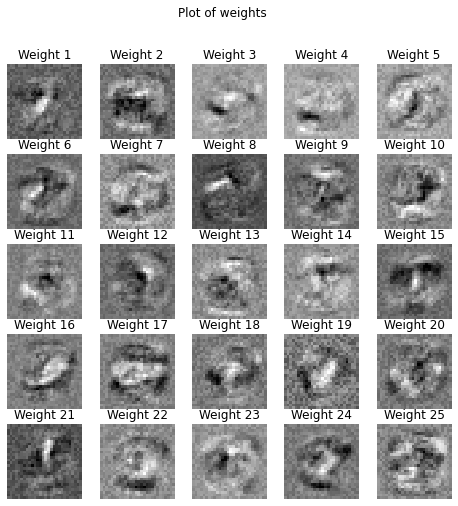

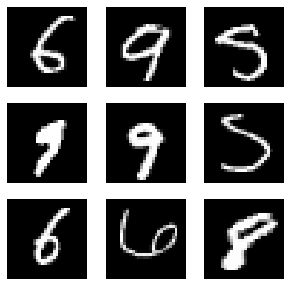

In [69]:
weightsOnly = thetaOneMatrixTrained[:, 1:]


figWeights, axWeights = plt.subplots(5, 5, figsize = (8, 8))
counter = 0
for row in range(0, len(axWeights)):
    for col in range(0, len(axWeights)):
        axWeights[row, col].imshow(weightsOnly[counter,:].reshape(28,28),
                                      cmap = "gray", interpolation = "none")
        axWeights[row, col].set_title("Weight " + str(counter + 1))
        axWeights[row, col].set_axis_off()
        counter += 1
figWeights.suptitle("Plot of weights")

#plot a few digits for comparison:

figDigits, axDigits = plt.subplots(3, 3, figsize = (5,5))
counter = 0
for row in range(0, len(axDigits)):
    for col in range(0, len(axDigits)):
        digit = np.reshape(X_train[counter + np.ceil(np.random.rand() * 10000).astype(int), :], newshape = (28,28))
        axDigits[row, col].imshow(digit, cmap = "gray", interpolation = "none")
        axDigits[row, col].set_axis_off()
        counter += 1
        

## Understanding the weights

It's not too clear what _exactly_ the weights are capturing, but some weights really seem to be capturing specific strokes, just like in the 3Blue1Brown video. For example, weight 5 seems to capture the upward stroke of a 1 or 7, and weight 20 seems to be capturing something vaguely 8-like.

## (Optional) Keras convolutional neural network on MNIST data

Hi it's me the notice that this is optional and that you're free to skip this: **this is optional**! An accuracy of 93% on the test set is nothing to scoff at, but you know that convolutional neural networks (along with other innovations like Dropout and other activation functions) are what made the real leaps in performance possible. Using the Keras library, you can easily train your own convolutional neural network. 

I will discuss Keras in a bit more detail next Monday. For now, you can do the following:

* Go [here](https://keras.io/examples/vision/mnist_convnet/) and input the commands there into the code cell(s) below. You could copy all the code, but typing it yourself might give you more of an idea of what you're doing so it's probably preferable.
* As you step through it b sure to search for things you don't know about and think about the dimensionality. What is the total dimensionality of the data after you've run 32 convolutional filters over it? `model.summary()` shows this, but see if you get it.
* As an optionalception question: you could try to get the untrained and trained filter weights and visualise them to see what sort of features in the image each filter has become attuned to. See [this question on Stackoverflow](https://stackoverflow.com/questions/43305891/how-to-correctly-get-layer-weights-from-conv2d-in-keras?noredirect=1&lq=1) and [this link about getting weights from a Keras model](https://www.codespeedy.com/get_weights-and-set_weights-functions-in-keras-layers/).